In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch

import os
# Set GPU ID
os.environ["CUDA_VISIBLE_DEVICES"]="1"
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu'
)
import deepinv as dinv
from tqdm import tqdm
from ProxNest.sampling import resampling
import ProxNest as pxn


# Load image

In [6]:
import torchvision
from PIL import Image

In [28]:


# Load Image
dim = 256
x_true = np.load('../../data/butterfly_{}.npy'.format(dim))

# Normalise magnitude
x_true -= np.nanmin(x_true)
x_true /= np.nanmax(x_true)
x_true[x_true<0] = 0

# To pytorch
x_true = torch.Tensor(x_true).to(device)
x = x_true.clone().to(device)


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [22]:

# formatted = (x_true * 255 / np.max(x_true)).astype('uint8')[0,:,:,:]
# print(formatted.shape)
# img = Image.fromarray(np.moveaxis(formatted, 0, 2))
# x_true = torchvision.transforms.functional.to_grayscale(img, num_output_channels=1)


(3, 256, 256)


## Define model and generate observations

In [3]:
# Define noise parameters
ISNR = 20
sigma = np.sqrt(np.mean(np.abs(x_true.cpu().numpy())**2)) * 10**(-ISNR/20)

print('sigma*255: ', sigma*255)
# Define the forward operator
blur_kernel_size = 5

physics = dinv.physics.BlurFFT(
    img_size=(3, x.shape[-2], x.shape[-1]),
    filter=torch.ones(
        (1, 1, blur_kernel_size, blur_kernel_size),
        device=device
    ) / blur_kernel_size**2,
    device=device,
    noise_model=dinv.physics.GaussianNoise(sigma=sigma),
)

# Compute observations
y = physics(x)



sigma*255:  13.653015464544296


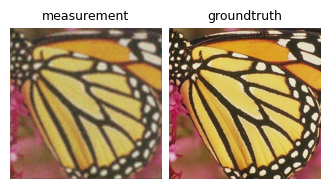

In [4]:
# Plot observations and true x

imgs = [y, x_true]
titles=["measurement", "groundtruth"]
dinv.utils.plotting.plot(
    imgs,
    titles=titles,
)

## Define parameters and initialise denoising model

In [5]:
# Options dictionary associated with the overall sampling algorithm
options = {
    'samplesL': 1e1,        # Number of live samples
    'samplesD': 2e1,      # Number of discarded samples 
       'sigma': sigma,      # Noise standard deviation of degraded image
        'tol' : 1e-6,      # Convergence tolerance of algorithm (Ball projection alg)
   'max_iter' : 200,        # Maximum number of iterations (Ball projection alg)
    'verbose' : True,       # Verbosity
}

diff_params = {
         'model_type' : 'imagenet',     # Type of pretrained model. Options are 'imagenet' or 'ffhq'
        'in_channels' : 3,              # Channels in the input Tensor.
       'out_channels' : 3,              # Channels in the output Tensor.
        'sigma_noise' : sigma,          # Noise standard deviation of degraded image
    'diffusion_steps' : 100,            # Maximum number of iterations of the DiffPIR algorithm
            'lambda_' : 7.0,            # Regularisation parameter
               'zeta' : 0.5,            # DiffPIR parameter controling the diffusion
}


# Gaussian log likelihood
LogLikeliL = lambda x_current, y, physics, sigma : - torch.nn.functional.mse_loss(
    y,
    physics.A(x_current), # Apply the forward model (without the noise addition)
    reduction='sum'
) / (2*sigma**2)

LikeliL = LogLikeliL

# Load the denoiser for the diffusion model 
if diff_params['model_type'] == 'imagenet':
    model_path = "/disk/xray99/tl3/pretrained_diffusions/diffpir_pretrained_models/256x256_diffusion_uncond.pt"
    large_model = True
elif diff_params['model_type'] == 'ffhq':
    model_path = "/disk/xray99/tl3/pretrained_diffusions/diffpir_pretrained_models/diffusion_ffhq_10m.pt"
    large_model = False

denoising_model = dinv.models.DiffUNet(
    in_channels=diff_params['in_channels'],
    out_channels=diff_params['out_channels'],
    pretrained=model_path,
    large_model=large_model
).to(device)



## Init model

In [6]:
x_init = physics.A_adjoint(y)

In [7]:


diffnest = pxn.sampling.diff_nested.DiffusionNestedSampling(
    x_init=x_init,
    y=y,
    denoising_model=denoising_model,
    physics=physics,
    LogLikeliL=LogLikeliL,
    options=options,
    diff_params=diff_params,
    device=device
)



In [8]:
# Run
BayEvi, Xtrace = diffnest.run()


DiffNest || Populate: 100%|██████████| 10/10 [01:05<00:00,  6.52s/it]
DiffNest || Sample: 100%|██████████| 20/20 [05:03<00:00, 15.18s/it]
DiffNest || Compute Weights: 100%|██████████| 20/20 [00:00<00:00, 227333.55it/s]
DiffNest || Trapezium Integrate: 100%|██████████| 18/18 [00:00<00:00, 344737.32it/s]
ProxNest || Estimate Variance: 100%|██████████| 20/20 [00:00<00:00, 186413.51it/s]
ProxNest || Compute Posterior Mean: 100%|██████████| 20/20 [00:00<00:00, 206108.30it/s]


In [9]:
BayEvi

array([-0.69437367,  0.16159697])

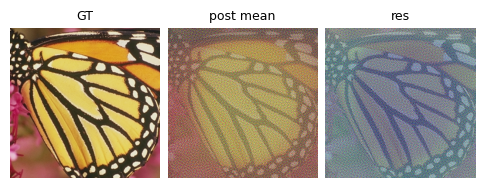

In [10]:
imgs = [x_true, Xtrace["DiscardPostMean"], x_true-Xtrace["DiscardPostMean"]]
titles=["GT", "post mean", "res"]
dinv.utils.plotting.plot(
    imgs,
    titles=titles,
)


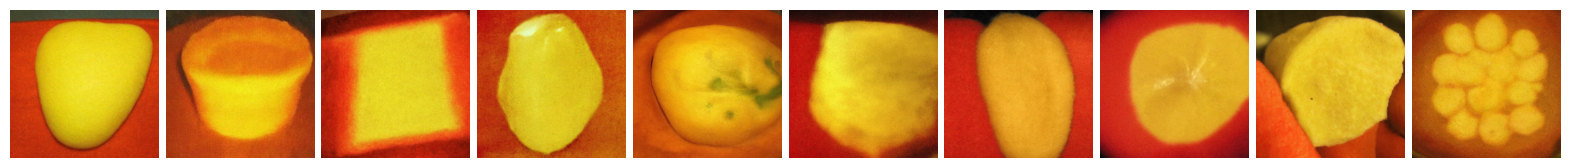

In [14]:
imgs = [_x for _x in Xtrace["Discard"][:10]]
titles=["GT", "post mean", "res"]
dinv.utils.plotting.plot(
    imgs,
    # titles=titles,
)

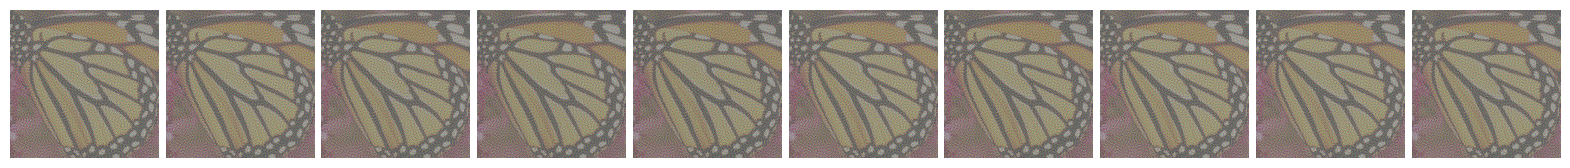

In [12]:
imgs = [_x for _x in Xtrace["LiveSet"]]
titles=["GT", "post mean", "res"]
dinv.utils.plotting.plot(
    imgs,
    # titles=titles,
)